In [1]:
import pickle
import pandas as pd
import numpy as np
import os, glob
import matplotlib.pyplot as plt

In [154]:
path = os.getcwd()
path

'/home/m.shah/projects/models/rnn'

In [155]:
dfs = []

for filename in glob.glob(os.path.join(path, "../../data/simulated-data-raw/", "data", "*.pkl")):
    with open(filename, 'rb') as f:
        temp = pd.read_pickle(f)
        dfs.append(temp)
df = pd.DataFrame()
df = df.append(dfs)


### Portions of Fraud/Normal data

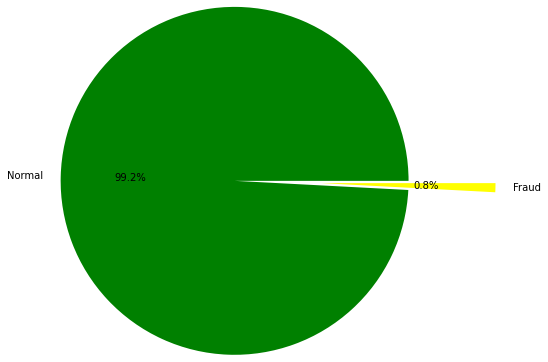

In [156]:
portions = df["TX_FRAUD"].value_counts().to_dict()
plt.pie(portions.values(), 
        portions.keys(),
        labels = ["Normal", "Fraud"], 
        radius = 2,
        autopct='%1.1f%%',
       colors = ["green", "yellow"])
plt.show()

### Distribution of Transactions per Customer

In [157]:
customer_tx_count = df["CUSTOMER_ID"].value_counts().to_dict()
max(list(customer_tx_count.keys())), max(list(df["CUSTOMER_ID"]))

(4999, 4999)

<AxesSubplot:ylabel='Density'>

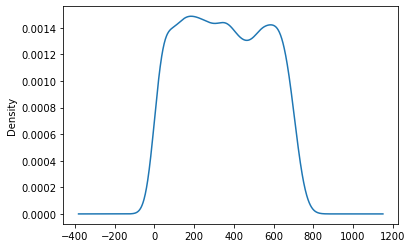

In [158]:
pd.Series(list(customer_tx_count.values())).plot(kind = 'density')

## Preprocessing

In [159]:
class PreProcessor:    
    def __init__(self):
        pass
    def noramlize(self):
        pass
    
    def pre_process(self, 
                    input_data, 
                    feature_columns,
                    label_columns,
                   categorical = None):
        data_x = pd.DataFrame(input_data[feature_columns])
        data_y= pd.DataFrame(input_data[label_columns])
        #OneHotEncoding
        if categorical[0] is not None:
            data_x = pd.get_dummies(data_x, columns = categorical[0])
        if categorical[1] is not None:
            data_y = pd.get_dummies(data_y, columns = categorical[1])
        return data_x, data_y

In [160]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
from sklearn.metrics import cohen_kappa_score
from sklearn.metrics import roc_auc_score
from sklearn.metrics import confusion_matrix


In [161]:
#Feature Define
if "WEEK_DAY" not in df.columns:
    df.insert(7, "WEEK_DAY", df["TX_DATETIME"].apply(lambda x : x.weekday()))

#Feature Selection
selected_features = ["CUSTOMER_ID", 
                     "TERMINAL_ID", 
                     'TX_AMOUNT', 
                     'TX_TIME_SECONDS', 
                     'TX_TIME_DAYS', 
                     "WEEK_DAY"]

In [24]:
df.iloc[:,0:9]

,TRANSACTION_ID,TX_DATETIME,CUSTOMER_ID,TERMINAL_ID,TX_AMOUNT,TX_TIME_SECONDS,TX_TIME_DAYS,WEEK_DAY,TX_FRAUD
0,0,2018-04-01 00:00:31,596,3156,57.16,31,0,6,0
1,1,2018-04-01 00:02:10,4961,3412,81.51,130,0,6,0
2,2,2018-04-01 00:07:56,2,1365,146.00,476,0,6,0
3,3,2018-04-01 00:09:29,4128,8737,64.49,569,0,6,0
4,4,2018-04-01 00:10:34,927,9906,50.99,634,0,6,0
...,...,...,...,...,...,...,...,...,...
1754150,1754150,2018-09-30 23:56:36,161,655,54.24,15810996,182,6,0
1754151,1754151,2018-09-30 23:57:38,4342,6181,1.23,15811058,182,6,0
1754152,1754152,2018-09-30 23:58:21,618,1502,6.62,15811101,182,6,0
1754153,1754153,2018-09-30 23:59:52,4056,3067,55.40,15811192,182,6,0


In [162]:
pre_processor = PreProcessor()

data_x, data_y = pre_processor.pre_process(df.iloc[:,:9], 
                                           selected_features,
                                           ["TX_FRAUD"],
                                          categorical = [["WEEK_DAY"], ["TX_FRAUD"]])

train_x, test_x, train_y, test_y = train_test_split(data_x, data_y, test_size = 0.2)

In [163]:
train_x.shape

(1403324, 12)

In [164]:
train_y.shape

(1403324, 2)

In [121]:
train_x = train_x.astype('float32')
test_x = test_x.astype('float32')

# reshape input to be [samples, time steps, features]

# train_x = np.reshape(train_x[:1403318], (200474, params[1], params[2]))
# test_x = np.reshape(test_x[:350826],(350826, test_params[1], test_params[2]))
# train_x.shape

In [165]:
train_x = train_x.values
train_y = train_y.values
test_x = test_x.values
test_y = test_y.values

## Model

In [2]:
from keras.models import Sequential
from keras.layers import SimpleRNN, LSTM, Dense, Dropout
from keras import backend as K

In [89]:
class LSTM_MODEL:
    def __init__(self,
                 input_shape,
                 lstm_units,
                 n_outputs = 1):
        self.model = Sequential()
        self.model.add(LSTM(units = lstm_units, input_shape = input_shape))
        self.model.add(Dropout(0.5))
        self.model.add(Dense(n_outputs, activation = "sigmoid"))
        self.model.build()
        print("Model Summary: \n\n", self.model.summary())
        
    def train(self, train_x, train_y, batch_size = 100):
        self.model.compile(loss='categorical_crossentropy', 
                           optimizer='adam',
                           metrics=['accuracy'])
        result = self.model.fit(train_x, train_y, batch_size = batch_size, epochs = 1)
        return result
    
    def evaluate(self, train_x, train_y):
        _, train_loss = self.model.evaluate(train_x, train_y)
        print("Train Loss is: %f" %train_loss)
        
    def predict_classes(self, test_x):
        return self.model.predict_classes(test_x)

In [170]:
#PARAMS
time_window = 128 

train_samples, n_features = train_x.shape[0], train_x.shape[1]
params = train_samples, time_window, n_features

test_samples = test_x.shape[0]
test_params =  test_samples, time_window, n_features


params, test_params

((1403324, 128, 12), (350831, 128, 12))

In [175]:
n_outputs = train_y.shape[1]

In [171]:
train_x = train_x[:train_samples - (train_samples % time_window)].reshape(-1, 128, 12)
test_x = test_x[:test_samples - (test_samples % time_window)].reshape(-1, 128, 12)

In [179]:
train_y = train_y[:train_samples - (train_samples % time_window)].reshape(-1, n_outputs)

In [180]:
test_y = test_y[:test_samples - (test_samples % time_window)].reshape(-1, n_outputs)

In [184]:
train_x.shape, train_y.shape, test_x.shape, test_y.shape

((10963, 128, 12), (1403264, 2), (2740, 128, 12), (350720, 2))

In [127]:
model = LSTM_MODEL(input_shape = (params[1], params[2]),
                   lstm_units = 5, 
                  n_outputs = 2)

Model: "sequential_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_7 (LSTM)                (None, 5)                 360       
_________________________________________________________________
dropout_5 (Dropout)          (None, 5)                 0         
_________________________________________________________________
dense_5 (Dense)              (None, 2)                 12        
Total params: 372
Trainable params: 372
Non-trainable params: 0
_________________________________________________________________
Model Summary: 

 None


In [117]:
train_y[:1403318].reshape(-1, params[1]).shape

(200474, 7)

In [118]:
train_x[:1403318].reshape(-1, params[1], params[2]).shape

(200474, 7, 12)

In [122]:
model.train(train_x[:1403318].reshape(-1, params[1], params[2]), train_y[:1403318].reshape(-1, params[1]))

2005/2005 [==============================] - 43s 20ms/step - loss: 0.4024 - accuracy: 0.0080


In [48]:
model.evaluate(test_x.reshape(-1, test_params[1], test_params[2]), test_y.reshape(-1, test_params[1]))

10964/10964 [==============================] - 26s 2ms/step - loss: 0.1274 - accuracy: 0.9917
Train Loss is: 0.991740


In [125]:
y_predict = model.predict_classes(test_x.reshape(-1, test_params[1], test_params[2]))

/home/m.shah/.conda/envs/tensorflow/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


In [129]:
print(np.unique(y_predict))
y_predict

[5]


array([5, 5, 5, ..., 5, 5, 5])

In [57]:
accuracy = accuracy_score(test_y.reshape(-1, test_params[1]), y_predict[:, 0])

ValueError: Classification metrics can't handle a mix of binary and continuous targets